In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

### Importing the product reviews data.

In [128]:
product_reviews = pd.read_csv('reviews.csv')

In [129]:
product_reviews.head()

,asin,name,date,rating,review
0,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-06,1,I bought this hair oil after viewing so many g...
1,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-14,5,Used This Mama Earth Newly Launched Onion Oil ...
2,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-10-19,1,So bad product...My hair falling increase too ...
3,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-16,1,Product just smells similar to navarathna hair...
4,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-18,5,I have been trying different onion oil for my ...


In [130]:
product_reviews.shape

(2782, 5)

In [131]:
product_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2782 entries, 0 to 2781
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   asin    2782 non-null   object
 1   name    2782 non-null   object
 2   date    2782 non-null   object
 3   rating  2782 non-null   int64 
 4   review  2778 non-null   object
dtypes: int64(1), object(4)
memory usage: 108.8+ KB


# Missing Values

In [132]:
missing = pd.concat([product_reviews.isnull().sum(), 100 * product_reviews.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by=['count', '%'],ascending=True)

,count,%
asin,0,0.000000
name,0,0.000000
date,0,0.000000
rating,0,0.000000
review,4,0.143781


In [133]:
product_reviews.dropna(inplace=True)

In [134]:
product_reviews = product_reviews.reset_index()
product_reviews = product_reviews.drop(['index'], axis = 1) 
product_reviews.head()

,asin,name,date,rating,review
0,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-06,1,I bought this hair oil after viewing so many g...
1,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-14,5,Used This Mama Earth Newly Launched Onion Oil ...
2,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-10-19,1,So bad product...My hair falling increase too ...
3,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-16,1,Product just smells similar to navarathna hair...
4,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-18,5,I have been trying different onion oil for my ...


In [135]:
product_reviews.shape

(2778, 5)

#### List of Unique Products

In [136]:
product_reviews['name'].nunique()

122

That is, we have a total of 122 unique products in the data set provided.

Number of reviews for each product 

In [137]:
product_reviews['name'].value_counts().head()

Tata-Tea-Gold-500g                     58
Patanjali-Saundarya-Aloe-Vera-150ml    40
Cinthol-Original-Soap-100g-Pack        40
Mamaearth-Face-Wash-100-ml             40
Himalaya-Baby-Shampoo-400-ml           40
Name: name, dtype: int64

### Now we will try to find the unique brands that these products belong to and the number of reviews each brand has. We can do this as we can see a pattern in the name and extracting the first word would give us the brand associated with the product.

In [138]:
product_reviews['brandName'] = product_reviews['name'].str.split('-').str[0]
product_reviews.head()

,asin,name,date,rating,review,brandName
0,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-06,1,I bought this hair oil after viewing so many g...,Mamaearth
1,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-14,5,Used This Mama Earth Newly Launched Onion Oil ...,Mamaearth
2,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-10-19,1,So bad product...My hair falling increase too ...,Mamaearth
3,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-16,1,Product just smells similar to navarathna hair...,Mamaearth
4,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-18,5,I have been trying different onion oil for my ...,Mamaearth


In [139]:
product_reviews['brandName'].unique()

array(['Mamaearth', 'Godrej', 'Titan', 'Maaza', 'Paper', 'Indiana',
       'Coca', 'Natural', 'Maggi', 'Glucon', 'Amul', 'Patanjali',
       'PATANJALI', 'Dettol', 'Savlon', 'Cinthol', 'Britannia',
       'NutriChoice', 'Streax', 'Himalaya', 'Society', 'Tata', 'Fastrack',
       'Reflex', 'MYSORE', 'Mysore'], dtype=object)

In [140]:
product_reviews['brandName'] = product_reviews['brandName'].str.replace('PATANJALI', 'Patanjali')
product_reviews['brandName'] = product_reviews['brandName'].str.replace('MYSORE', 'Mysore')

In [141]:
product_reviews['brandName'].nunique()

24

#### There are a total of 24 unique brands that have their product reviews in the dataset

In [142]:
product_reviews['brandName'].value_counts().head()

Mamaearth    200
Godrej       200
Titan        200
Himalaya     200
Cinthol      200
Name: brandName, dtype: int64

# Ratings for the top 5 Brands

In [143]:
cinthol_rat = product_reviews[product_reviews['brandName']=='Cinthol']
him_rat = product_reviews[product_reviews['brandName']=='Himalaya']
mam_rat = product_reviews[product_reviews['brandName']=='Mamaearth']
tit_rat = product_reviews[product_reviews['brandName']=='Titan']
god_rat = product_reviews[product_reviews['brandName']=='Godrej']

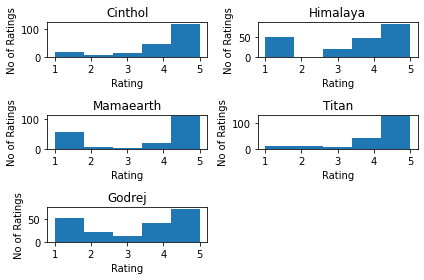

In [144]:
plt.subplot(3,2,1)
plt.hist(cinthol_rat['rating'],bins=5)
plt.title('Cinthol')
plt.xlabel('Rating')
plt.ylabel('No of Ratings')


plt.subplot(3,2,2)
plt.hist(him_rat['rating'],bins=5)
plt.title('Himalaya')
plt.xlabel('Rating')
plt.ylabel('No of Ratings')


plt.subplot(3,2,3)
plt.hist(mam_rat['rating'],bins=5)
plt.title('Mamaearth')
plt.xlabel('Rating')
plt.ylabel('No of Ratings')


plt.subplot(3,2,4)
plt.hist(tit_rat['rating'],bins=5)
plt.title('Titan')
plt.xlabel('Rating')
plt.ylabel('No of Ratings')


plt.subplot(3,2,5)
plt.hist(god_rat['rating'],bins=5)
plt.title('Godrej')
plt.xlabel('Rating')
plt.ylabel('No of Ratings')

plt.tight_layout()
plt.show()


# Ratings of the bottom 5 Brands

In [145]:
product_reviews['brandName'].value_counts().tail()

Savlon         20
Glucon         20
Maggi          20
NutriChoice    12
Indiana         6
Name: brandName, dtype: int64

In [146]:
mag_rat = product_reviews[product_reviews['brandName']=='Maggi']
maaz_rat = product_reviews[product_reviews['brandName']=='Maaza']
sav_rat = product_reviews[product_reviews['brandName']=='Savlon']
nutri_rat = product_reviews[product_reviews['brandName']=='NutriChoice']
ind_rat = product_reviews[product_reviews['brandName']=='Indiana']

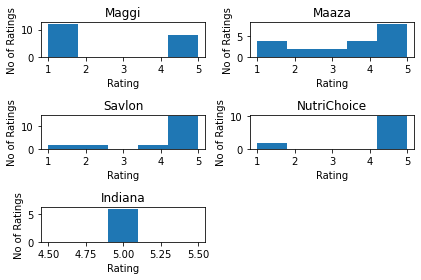

In [147]:
plt.subplot(3,2,1)
plt.hist(mag_rat['rating'],bins=5)
plt.title('Maggi')
plt.xlabel('Rating')
plt.ylabel('No of Ratings')


plt.subplot(3,2,2)
plt.hist(maaz_rat['rating'],bins=5)
plt.title('Maaza')
plt.xlabel('Rating')
plt.ylabel('No of Ratings')


plt.subplot(3,2,3)
plt.hist(sav_rat['rating'],bins=5)
plt.title('Savlon')
plt.xlabel('Rating')
plt.ylabel('No of Ratings')


plt.subplot(3,2,4)
plt.hist(nutri_rat['rating'],bins=5)
plt.title('NutriChoice')
plt.xlabel('Rating')
plt.ylabel('No of Ratings')


plt.subplot(3,2,5)
plt.hist(ind_rat['rating'],bins=5)
plt.title('Indiana')
plt.xlabel('Rating')
plt.ylabel('No of Ratings')

plt.tight_layout()
plt.show()

# overall rating for entire range of indian products

<AxesSubplot:>

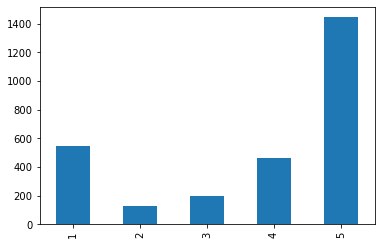

In [148]:
product_reviews['rating'].value_counts().sort_index().plot(kind='bar')

# Percent of customers completely satisfied

In [149]:
star_5 = product_reviews[product_reviews['rating']==5]
per_5 = (star_5['rating'].count()/len(product_reviews))*100

In [150]:
print(per_5)

51.97984161267099


In [151]:
star_5['review'].count()

1444

That is 51% customers have given a 5 star rating overall and that we have 1444 reviews that should have a positive sentiment towards the product.

# Percent of customers not at all satisfied

In [152]:
star_1 = product_reviews[product_reviews['rating']==1]
per_1 = (star_1['rating'].count()/len(product_reviews))*100
print(per_1)
star_1['review'].count()

19.654427645788335


546

That is 19% customers have given a 1 star rating overall and that we have 546 reviews that should have a negative sentiment towards the product.

# Wordcloud by rating

## 1 star rating wordcloud

In [153]:
word_1 =  pd.DataFrame(product_reviews[product_reviews['rating']==1]['review'])

In [154]:
word_1 = word_1.reset_index()
word_1 = word_1.drop(['index'], axis = 1) 
word_1.head()

,review
0,I bought this hair oil after viewing so many g...
1,So bad product...My hair falling increase too ...
2,Product just smells similar to navarathna hair...
3,I purchased both oil and shampoo after watchin...
4,I bought this hair oil after viewing so many g...


In [155]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [156]:
import re
corpus1 = []
for i in range(0,len(word_1)):
    text = re.sub('[^a-zA-Z]', ' ', word_1['review'][i])
    text = text.lower()
    text = text.split()
    text = [word for word in text if not word in stop_words]
    text = ' '.join(text)
    corpus1.append(text)

In [157]:
filtered_words1 = [w.lower() for w in corpus1 if w not in stopwords.words('english')]

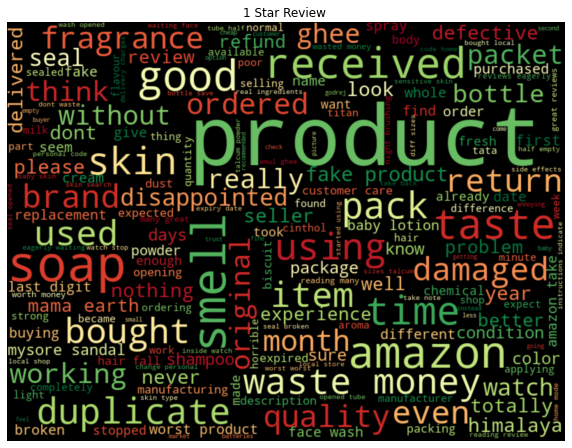

[('year old child cavity started developing bad breaths morning using toothpaste couple weeks day night brushing sessions feel toothpaste might actually cause cavity rather keep away experience immediately shifted back pigeon toothpaste night brushing bad breath stopped next day onward purchased natural properties mama earth team needs research ingredients product use mama earth products decent toothpaste though', 4), ('thick beads know want scrub face everyday foam like facewash smells like pulpy orange applying smells bit like turmeric washing face looked bright using bright previous facewashes made skin dry annoying since skin already dry without made worse definitely worth money got rs sale still worth think worked tan still dont see changes skin disappointing', 4), ('reading many great reviews eagerly waiting face wash opened tube half empty disappointed', 4), ('reading many great reviews eagerly waiting face wash opened tube half empty even packed disappointed', 4)]


In [158]:
from wordcloud import WordCloud , ImageColorGenerator
from collections import Counter
word_cloud = WordCloud(width = 800,
                       height = 600,
                       colormap = 'RdYlGn', 
                       margin = 0,
                       max_words = 200,  
                       min_word_length = 4,
                       max_font_size = 120, 
                       background_color = 'black').generate(' '.join(filtered_words1))

plt.figure(figsize = (10, 10))
plt.imshow(word_cloud, interpolation = 'gaussian')
plt.title('1 Star Review ')
plt.axis('off')
plt.show()
Counter1 = Counter(filtered_words1) 
most_occur1 = Counter1.most_common(4) 
print(most_occur) 

## 2 star review wordcloud

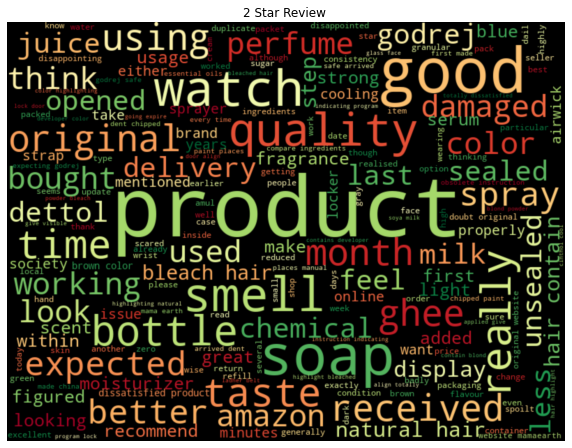

[('first made china product expecting godrej safe arrived dent chipped paint two places manual product obsolete instruction indicating program lock key key pad door align totally dissatisfied product quality', 4), ('color highlighting natural hair highlight bleached hair kit contain blond powder bleach hair contains developer color applied give visible result natural hair although seen sunlight get color desired', 4), ('product good final color must reddish color', 4), ('believe good name given premium literally nothing like premium putting six seven spoons still good taste plzzz aware go name', 4)]


In [159]:
from collections import Counter
word_2 =  pd.DataFrame(product_reviews[product_reviews['rating']==2]['review'])
word_2 = word_2.reset_index()
word_2 = word_2.drop(['index'], axis = 1) 
corpus2 = []
for i in range(0,len(word_2)):
    text = re.sub('[^a-zA-Z]', ' ', word_2['review'][i])
    text = text.lower()
    text = text.split()
    text = [word for word in text if not word in stop_words]
    text = ' '.join(text)
    corpus2.append(text)
filtered_words2 = [w.lower() for w in corpus2 if w not in stopwords.words('english')]
from wordcloud import WordCloud , ImageColorGenerator
word_cloud = WordCloud(width = 800,
                       height = 600,
                       colormap = 'RdYlGn', 
                       margin = 0,
                       max_words = 200,  
                       min_word_length = 4,
                       max_font_size = 120, 
                       background_color = 'black').generate(' '.join(filtered_words2))

plt.figure(figsize = (10, 10))
plt.imshow(word_cloud, interpolation = 'gaussian')
plt.title('2 Star Review ')
plt.axis('off')
plt.show()
Counter2 = Counter(filtered_words2) 
most_occur2 = Counter2.most_common(4) 
print(most_occur2)

## 3 star review wordcloud 

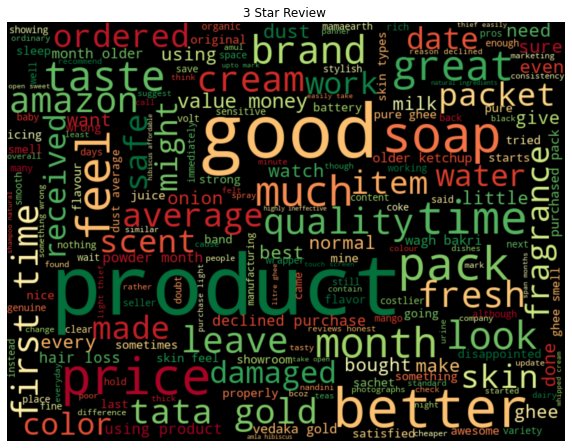

[('reason declined purchase light thief easily take open sweet time therefore declined purchase', 4), ('ok', 4), ('shampoo natural ingredients like amla hibiscus etc affordable however highly ineffective controlling hairfall dandruff also need use amount shampoo excessively oily dirty hair', 4), ('actually like product product effective hair using product felt like damaging hair', 4)]


In [160]:
word_3 =  pd.DataFrame(product_reviews[product_reviews['rating']==3]['review'])
word_3 = word_3.reset_index()
word_3 = word_3.drop(['index'], axis = 1) 
corpus3 = []
for i in range(0,len(word_3)):
    text = re.sub('[^a-zA-Z]', ' ', word_3['review'][i])
    text = text.lower()
    text = text.split()
    text = [word for word in text if not word in stop_words]
    text = ' '.join(text)
    corpus3.append(text)
filtered_words3 = [w.lower() for w in corpus3 if w not in stopwords.words('english')]
from wordcloud import WordCloud , ImageColorGenerator
word_cloud = WordCloud(width = 800,
                       height = 600,
                       colormap = 'RdYlGn', 
                       margin = 0,
                       max_words = 200,  
                       min_word_length = 4,
                       max_font_size = 120, 
                       background_color = 'black').generate(' '.join(filtered_words3))

plt.figure(figsize = (10, 10))
plt.imshow(word_cloud, interpolation = 'gaussian')
plt.title('3 Star Review ')
plt.axis('off')
plt.show()
Counter3 = Counter(filtered_words3) 
most_occur3 = Counter3.most_common(4) 
print(most_occur3)

## 4 star Review wordcloud 

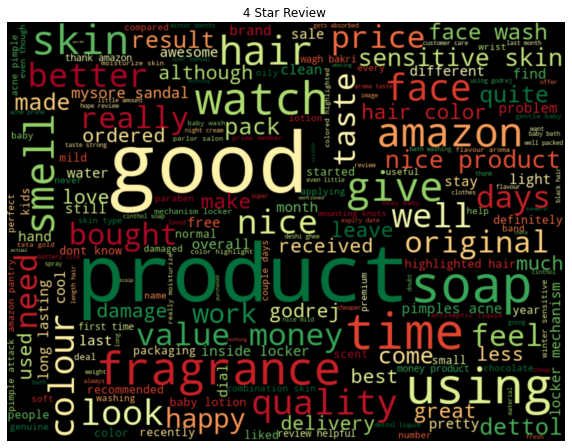

[('good', 28), ('nice product', 6), ('bought years baby mentioned even child gulps also harmful although trying best teach little one spit brushing happy product', 4), ('oily combination skin monsoons skin becomes even oilier due humidity also becomes prone breakouts using face wash quite time works amazing skin extracts excess oil skin leaves clean dehydrated also faced breakout face since started using', 4)]


In [161]:
word_4 =  pd.DataFrame(product_reviews[product_reviews['rating']==4]['review'])
word_4 = word_4.reset_index()
word_4 = word_4.drop(['index'], axis = 1) 
corpus4 = []
for i in range(0,len(word_4)):
    text = re.sub('[^a-zA-Z]', ' ', word_4['review'][i])
    text = text.lower()
    text = text.split()
    text = [word for word in text if not word in stop_words]
    text = ' '.join(text)
    corpus4.append(text)
filtered_words4 = [w.lower() for w in corpus4 if w not in stopwords.words('english')]
from wordcloud import WordCloud , ImageColorGenerator
word_cloud = WordCloud(width = 800,
                       height = 600,
                       colormap = 'RdYlGn', 
                       margin = 0,
                       max_words = 200,  
                       min_word_length = 4,
                       max_font_size = 120, 
                       background_color = 'black').generate(' '.join(filtered_words4))

plt.figure(figsize = (10, 10))
plt.imshow(word_cloud, interpolation = 'gaussian')
plt.title('4 Star Review ')
plt.axis('off')
plt.show()

Counter4 = Counter(filtered_words4) 
most_occur4 = Counter4.most_common(4) 
print(most_occur4)

## 5 star review wordcloud

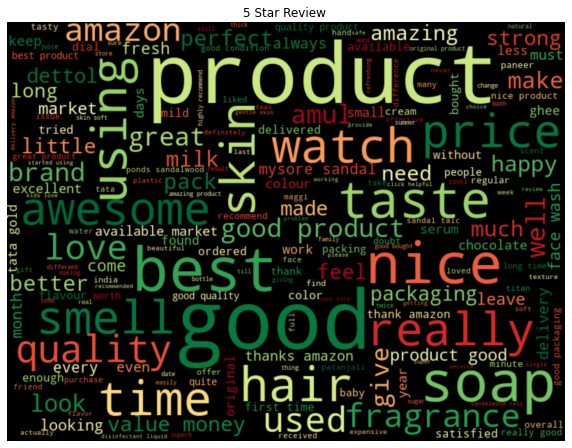

[('good', 36), ('good product', 18), ('nice', 16), ('tasty', 8)]


In [162]:
word_5 =  pd.DataFrame(product_reviews[product_reviews['rating']==5]['review'])
word_5 = word_5.reset_index()
word_5 = word_5.drop(['index'], axis = 1) 
corpus5 = []
for i in range(0,len(word_5)):
    text = re.sub('[^a-zA-Z]', ' ', word_5['review'][i])
    text = text.lower()
    text = text.split()
    text = [word for word in text if not word in stop_words]
    text = ' '.join(text)
    corpus5.append(text)
filtered_words5 = [w.lower() for w in corpus5 if w not in stopwords.words('english')]
from wordcloud import WordCloud , ImageColorGenerator
word_cloud = WordCloud(width = 800,
                       height = 600,
                       colormap = 'RdYlGn', 
                       margin = 0,
                       max_words = 200,  
                       min_word_length = 4,
                       max_font_size = 120, 
                       background_color = 'black').generate(' '.join(filtered_words5))

plt.figure(figsize = (10, 10))
plt.imshow(word_cloud, interpolation = 'gaussian')
plt.title('5 Star Review ')
plt.axis('off')
plt.show()

Counter5 = Counter(filtered_words5) 
most_occur5 = Counter5.most_common(4) 
print(most_occur5)

## Using Textblob to determine the sentiment of a review

In [163]:
from textblob import TextBlob
def polarity(text):
    return TextBlob(text).sentiment.polarity

product_reviews['polarity_score'] = product_reviews['review'].\
   apply(lambda x : polarity(x))

def sentiment(x):
    if x<0:
        return 'negative'
    elif x==0:
        return 'neutral'
    else:
        return 'positive'
    
product_reviews['polarity'] = product_reviews['polarity_score'].\
   map(lambda x: sentiment(x))

In [164]:
product_reviews.head()

,asin,name,date,rating,review,brandName,polarity_score,polarity
0,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-06,1,I bought this hair oil after viewing so many g...,Mamaearth,0.039028,positive
1,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-14,5,Used This Mama Earth Newly Launched Onion Oil ...,Mamaearth,0.327189,positive
2,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-10-19,1,So bad product...My hair falling increase too ...,Mamaearth,-0.700000,negative
3,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-16,1,Product just smells similar to navarathna hair...,Mamaearth,-0.076935,negative
4,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-18,5,I have been trying different onion oil for my ...,Mamaearth,0.286813,positive


In [165]:
product_reviews['polarity'].value_counts()

positive    2134
negative     410
neutral      234
Name: polarity, dtype: int64

In [166]:
product_reviews['rating'].value_counts()

5    1444
1     546
4     460
3     198
2     130
Name: rating, dtype: int64

In [167]:
rev = product_reviews.sort_values(by=['rating'],ascending=True)

In [168]:


new_df = rev[['review','rating']]
new_df = new_df.reset_index()
new_df = new_df.drop(['index'], axis = 1)

lst = []

for i in range(0,len(new_df)):
    text = re.sub('[^a-zA-Z]', ' ', new_df['review'][i])
    text = text.lower()
    text = text.split()
    text = [word for word in text if not word in stop_words]
    text = ' '.join(text)
    lst.append(text)

new_df['review'] = lst
new_df.head()

,review,rating
0,bought hair oil viewing many good comments pro...,1
1,got expired pack,1
2,sheer waste money milk got curdled last two oc...,1
3,never buy giving duplicate product original gh...,1
4,ordered patangali leter pouches correct weight...,1


In [169]:
X = new_df['review']
y = new_df['rating']

In [170]:
countVect = CountVectorizer()

In [171]:
Vector_words = countVect.fit_transform(X)

In [172]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection

In [173]:
X_train, X_test, y_train, y_test = train_test_split(Vector_words,y,test_size=0.3,random_state=42)

ne = list(range(1,30,2))
cv_score = []

In [174]:
for k in ne:
 knn = KNeighborsClassifier(n_neighbors=k)
 scores = cross_val_score(knn,X_train,y_train,cv=5,scoring='accuracy')
 cv_score.append(scores.mean())

optimal_k = ne[cv_score.index(max(cv_score))]

print('Optimal value of k is %d.' % optimal_k)

Optimal value of k is 1.


[0.7962976704741207, 0.632702144011873, 0.5678809000079506, 0.5689290541435877, 0.5442344897039726, 0.5267458193093578, 0.5190350621471921, 0.5180028092120954, 0.5108022155672753, 0.5118371187024621, 0.5113243049850263, 0.5133782100548591, 0.5133755598547689, 0.5113243049850263, 0.5113229798849812]


In [180]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf = TfidfVectorizer()
vect = tf_idf.fit_transform(X)

In [181]:
terms = tf_idf.get_feature_names()

In [184]:
vect.shape

(2778, 4471)

In [185]:
X_train, X_test, y_train, y_test = train_test_split(vect,y,train_size = 0.3,random_state=42)

In [194]:
kn = KNeighborsClassifier(n_neighbors=9)
kn.fit(X_train,y_train)
pred = kn.predict(X_test)
acc = accuracy_score(y_test,pred,normalize=True)
print(acc)

0.5403598971722365
